In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
import itertools
import re
from math import sqrt
import os
import warnings
import datetime

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

E:\Ananconda_Installation\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\Ananconda_Installation\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
E:\Ananconda_Installation\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# 1. Reading Data

In [2]:
df_unemployment=pd.read_csv(r'E:\Jupyter notebooks\hackathon23_somnolence\data\raw\third_party\oecd\Unemployment_Rate_OECD.csv')
df_unemployment.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HUR,TOT,PC_LF,A,1967,1.875,NaN
1,AUS,HUR,TOT,PC_LF,A,1968,1.850,NaN
2,AUS,HUR,TOT,PC_LF,A,1969,1.800,NaN
3,AUS,HUR,TOT,PC_LF,A,1970,1.625,NaN
4,AUS,HUR,TOT,PC_LF,A,1971,1.925,NaN


In [3]:
df_unemployment['LOCATION'].unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN', 'FRA', 'DEU',
       'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'JPN', 'KOR', 'LUX', 'MEX',
       'NLD', 'NZL', 'NOR', 'POL', 'PRT', 'SVK', 'ESP', 'SWE', 'CHE',
       'TUR', 'GBR', 'USA', 'CHL', 'EST', 'ISR', 'SVN', 'OECD', 'G-7',
       'EA19', 'LVA', 'LTU', 'COL', 'EU27_2020', 'CRI'], dtype=object)

In [4]:
#Location variable to control country
location='CAN'

In [5]:
df_unemployment=df_unemployment[(df_unemployment['LOCATION']==location)&(df_unemployment['SUBJECT']=='TOT')].copy()
df_unemployment_monthly=df_unemployment[df_unemployment['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]
df_unemployment_monthly['TIME']=pd.to_datetime(df_unemployment_monthly['TIME'],format='%Y-%m')
df_unemployment_monthly=df_unemployment_monthly.set_index('TIME')

C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_15892\495960325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unemployment_monthly['TIME']=pd.to_datetime(df_unemployment_monthly['TIME'],format='%Y-%m')


In [6]:
df_unemployment_monthly

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,Value,Flag Codes
TIME,,,,,,,
1955-01-01,CAN,HUR,TOT,PC_LF,M,4.8,NaN
1955-02-01,CAN,HUR,TOT,PC_LF,M,4.7,NaN
1955-03-01,CAN,HUR,TOT,PC_LF,M,4.9,NaN
1955-04-01,CAN,HUR,TOT,PC_LF,M,4.5,NaN
1955-05-01,CAN,HUR,TOT,PC_LF,M,4.5,NaN
...,...,...,...,...,...,...,...
2022-11-01,CAN,HUR,TOT,PC_LF,M,5.1,NaN
2022-12-01,CAN,HUR,TOT,PC_LF,M,5.0,NaN
2023-01-01,CAN,HUR,TOT,PC_LF,M,5.0,NaN


# 2. Univariate Time Series ARIMA

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

## 2.1. EDA

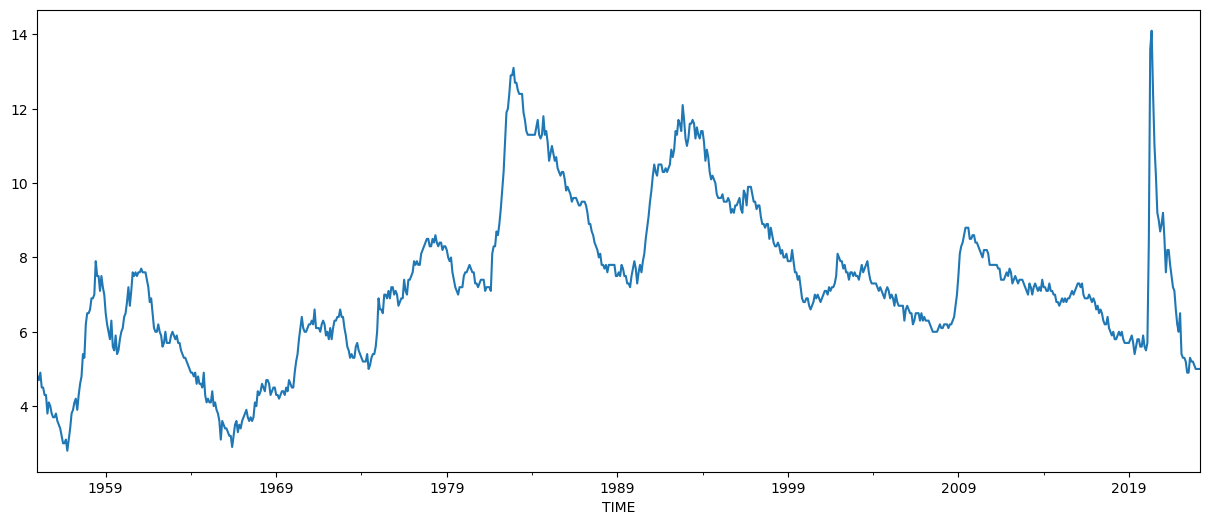

In [7]:
df_unemployment_monthly['Value'].plot(figsize=(15, 6))
plt.show()

### 2.1.1. Decomposing Time Series to Trend, Seasonality and Residuals

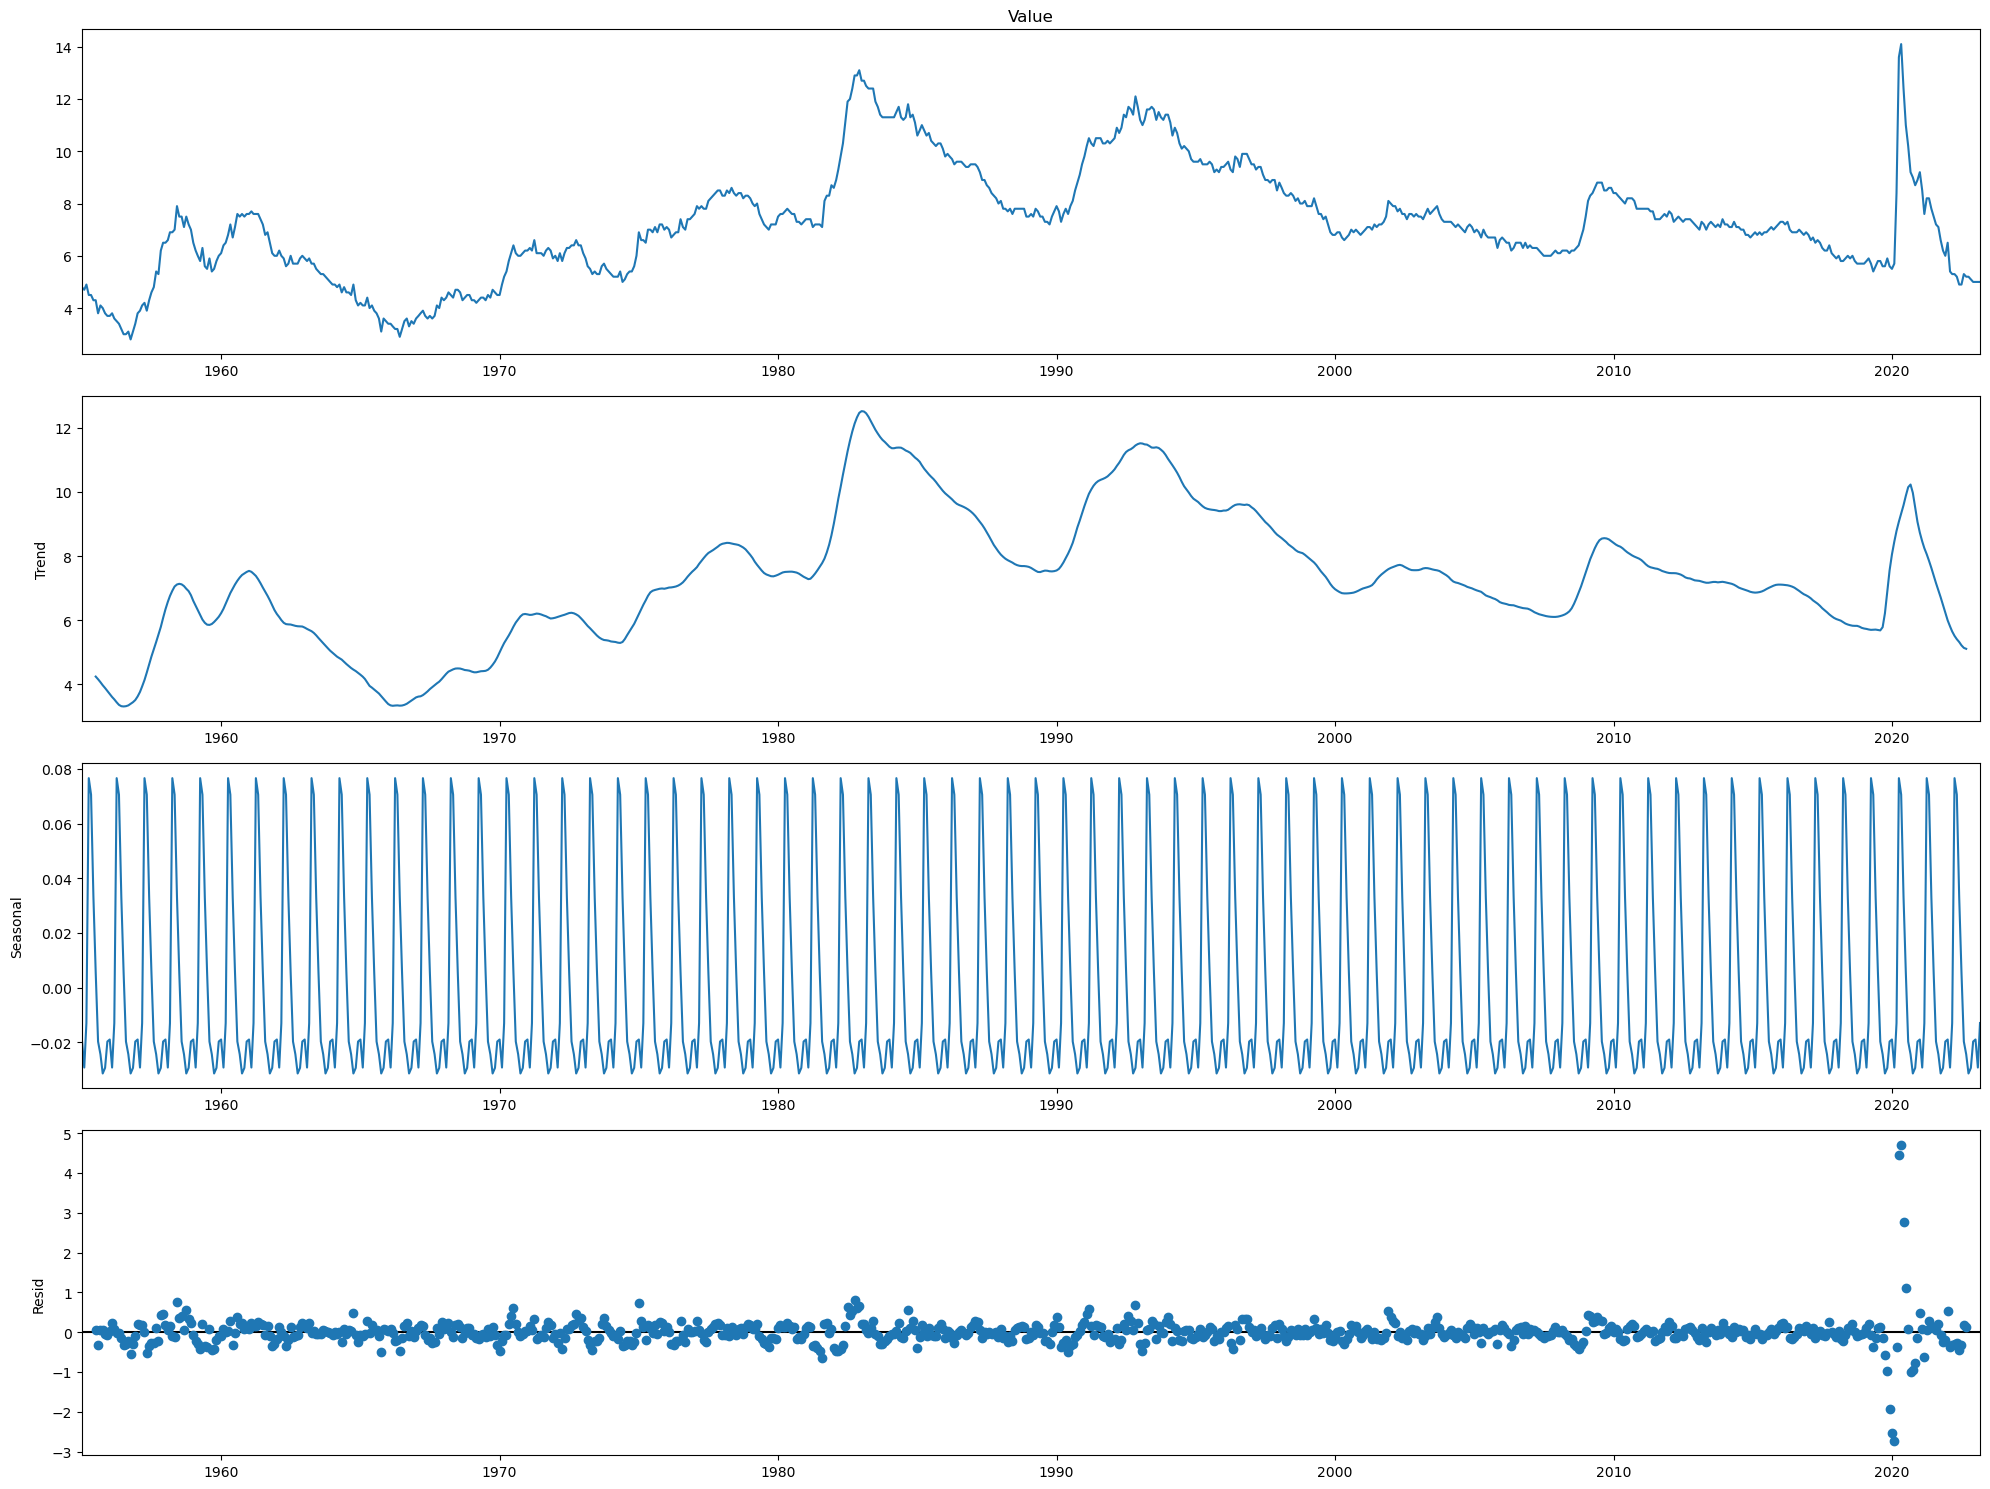

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 15
decomposition = sm.tsa.seasonal_decompose(df_unemployment_monthly['Value'], model='additive')
fig = decomposition.plot()
plt.show()

### 2.1.2. Checking Stationarity

In [9]:
adfuller_result = adfuller(df_unemployment_monthly['Value'].values, autolag='AIC')
print('ADF statistics: ', adfuller_result[0])
print('p-value: ', adfuller_result[1])
if adfuller_result[1] >= 0.05:
    print('------Non-stationary time series. Checking first difference------------')
    df_unemployment_monthly_transformed = df_unemployment_monthly['Value'].diff().dropna()
    adfuller_result = adfuller(df_unemployment_monthly_transformed.values, autolag='AIC')
    print('ADF statistics at first difference: ', adfuller_result[0])
    print('p-value: ', adfuller_result[1])
else:
    print('Stationary time series')

ADF statistics:  -2.9063039099124395
p-value:  0.04461983410922836
Stationary time series


## 2.2. Modelling 

In [10]:
train_limit=df_unemployment_monthly.shape[0]-12

Y_train=df_unemployment_monthly.iloc[0:train_limit,5]
Y_validation=df_unemployment_monthly.iloc[train_limit:,5]
Y_full=df_unemployment_monthly.iloc[:,5]

### 2.2.1. Determining optimum p,d,q values

In [11]:
%%time

def evaluate_sarimax_model(Y_train, Y_validation, order):
    mod = sm.tsa.statespace.SARIMAX(Y_train,
                                    order=order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    
    predictions={}
    for date in Y_validation.index:
        pred=results.get_prediction(pd.to_datetime(date))
        predictions[date]=pred.predicted_mean[0]
        
    y_forecasted = np.array(list(predictions.values()))
    y_truth = Y_validation.values
    mse = ((y_forecasted - y_truth) ** 2).mean()
    return sqrt(mse)

def evaluate_arima_model(Y_train, Y_validation, order):
    mod = ARIMA(Y_train,
                order=order)
    results = mod.fit()
    
    predictions={}
    for date in Y_validation.index:
        pred=results.get_prediction(pd.to_datetime(date))
        predictions[date]=pred.predicted_mean[0]
        
    y_forecasted = np.array(list(predictions.values()))
    y_truth = Y_validation.values
    mse = ((y_forecasted - y_truth) ** 2).mean()
    return sqrt(mse)

def evaluate_models(dataset, validation_dataset,p_values,d_values,q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                rmse = evaluate_arima_model(dataset, validation_dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%s' % (order,rmse))

    print('Best ARIMA%s RMSE= %s' % (best_cfg, best_score))
    return best_cfg
    
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
best_cfg=evaluate_models(Y_train, Y_validation, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=2.202259515577315
ARIMA(0, 0, 1) RMSE=2.153764942939214
ARIMA(0, 0, 2) RMSE=2.1517545891736463
ARIMA(0, 1, 0) RMSE=0.2500000000000005
ARIMA(1, 1, 0) RMSE=0.22096774574204392
ARIMA(10, 2, 2) RMSE=0.15075467581347704
Best ARIMA(10, 2, 2) RMSE= 0.15075467581347704
Wall time: 1min 9s


In [12]:
# stepwise_fit = auto_arima(Y_train, start_p=0,max_p=10, start_d=2, max_d=3, start_q =0, max_q=3,trace=True,suppress_warnings=True)
# stepwise_fit.summary()

### 2.2.2. Fitting Model

In [13]:
mod = ARIMA(Y_train,order=best_cfg)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6600      0.047    -14.044      0.000      -0.752      -0.568
ar.L2          0.1865      0.027      6.954      0.000       0.134       0.239
ar.L3         -0.0925      0.024     -3.814      0.000      -0.140      -0.045
ar.L4         -0.0328      0.030     -1.087      0.277      -0.092       0.026
ar.L5          0.0056      0.034      0.164      0.869      -0.061       0.072
ar.L6          0.0006      0.035      0.018      0.986      -0.068       0.070
ar.L7         -0.0034      0.052     -0.065      0.948      -0.106       0.099
ar.L8          0.0345      0.038      0.910      0.363      -0.040       0.109
ar.L9          0.1238      0.048      2.589      0.010       0.030       0.218
ar.L10         0.0551      0.037      1.491      0.136      -0.017       0.127
ma.L1         -0.0451      0.084     -0.536      0.5

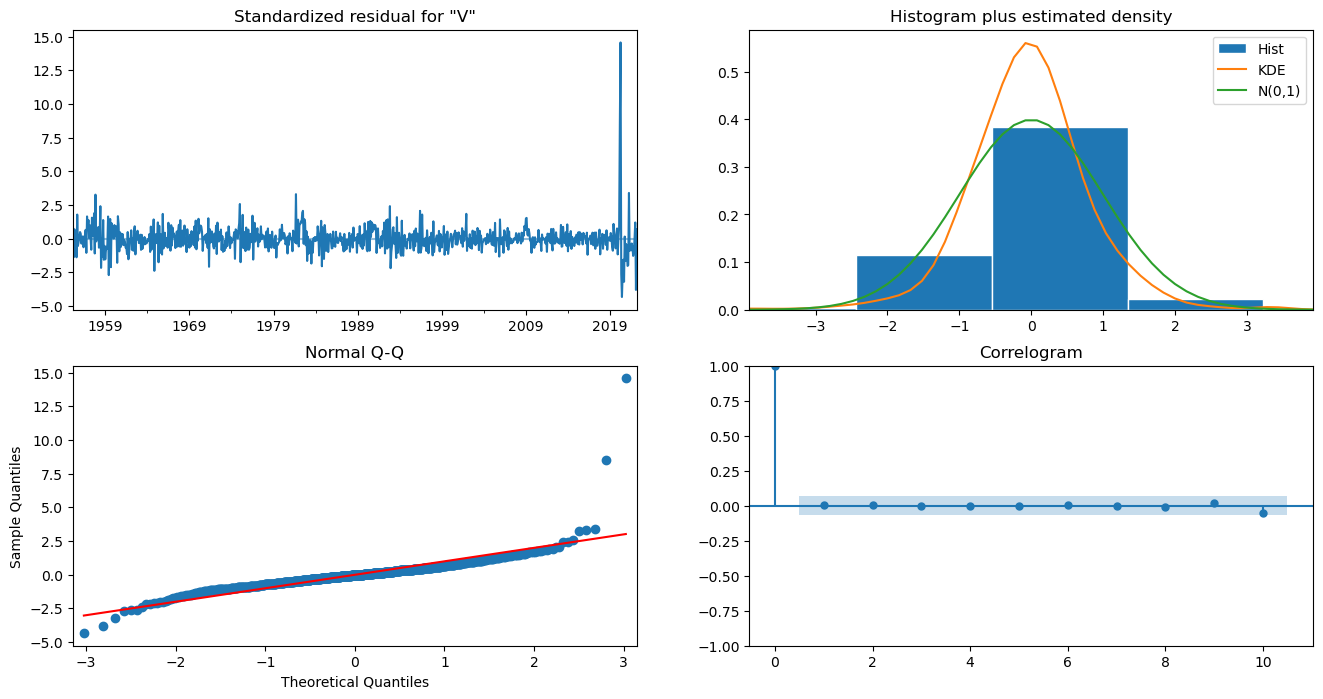

In [14]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### 2.2.3. Model Results

In [15]:
predictions={}
for date in Y_validation.index:
    pred=results.get_prediction(pd.to_datetime(date))
    predictions[date]=pred.predicted_mean[0]

In [16]:
y_forecasted = np.array(list(predictions.values()))
y_truth = Y_validation.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(sqrt(mse)))

The Root Mean Squared Error of our forecasts is 0.15075467581347704


### 2.2.4. Training on Full Data and Predicting

In [17]:
mod_full_data = ARIMA(Y_full,order=best_cfg)
results_full_data = mod_full_data.fit()
print(results_full_data.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6573      0.049    -13.525      0.000      -0.753      -0.562
ar.L2          0.1822      0.027      6.761      0.000       0.129       0.235
ar.L3         -0.0915      0.024     -3.853      0.000      -0.138      -0.045
ar.L4         -0.0283      0.030     -0.960      0.337      -0.086       0.029
ar.L5          0.0045      0.033      0.137      0.891      -0.060       0.069
ar.L6         -0.0071      0.035     -0.205      0.838      -0.075       0.061
ar.L7          0.0020      0.051      0.039      0.969      -0.098       0.102
ar.L8          0.0388      0.036      1.063      0.288      -0.033       0.110
ar.L9          0.1185      0.048      2.483      0.013       0.025       0.212
ar.L10         0.0554      0.037      1.501      0.133      -0.017       0.128
ma.L1         -0.0484      0.072     -0.673      0.5

In [18]:
preds_df = (results_full_data
            .get_prediction(start='2023-01-01', end='2023-05-01')
            .summary_frame(alpha=0.05)
)

preds_df

Value,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-01,4.951645,0.302140,4.359461,5.543829
2023-02-01,5.009688,0.302140,4.417505,5.601872
2023-03-01,4.962793,0.302140,4.370610,5.554976
2023-04-01,5.036106,0.302140,4.443923,5.628289
2023-05-01,5.055836,0.494355,4.086918,6.024754
